In [1]:
import numpy as np
import os
from pathlib import Path
import tqdm
import matplotlib.pyplot as plt
import random
import tqdm 

%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD

import keras.layers.advanced_activations as advanced_activations
import keras.activations as activations
import keras.layers as layers
from keras.layers import Dense, concatenate
from keras.callbacks import EarlyStopping

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, Conv3D, Conv3DTranspose
from tensorflow.keras.layers import MaxPooling3D
from tensorflow.keras.layers import AveragePooling3D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout, Add
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Model

Using TensorFlow backend.


In [3]:
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        self.accuracy = []
        
    def loss_plot(self):
        plt.plot(range(len(self.losses)), self.losses)
        
    def accuracy_plot(self):
        plt.plot(range(len(self.accuracy)), self.accuracy)

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.accuracy.append(logs.get('accuracy'))

        #print("Loss: {}, Val_loss: {}, Accuracy: {}".format(logs.get('loss'), logs.get('loss'), logs.get('accuracy')))


In [4]:
tf.__version__

'2.3.0'

### Dataset

In [46]:
past_frames = 10
future_frames = 4
step = 1
img_size = 256
train_size = 0.9

In [47]:
root = "../datasets/baganza/"
minis =  os.listdir(root)

# indices is aligned with that
dataset_filenames = [x for x in sorted(minis) if x.startswith("mini-")]

# handpicked intervals
dataset_intervals = [(300, 800), (300, 800), (390, 900), (300, 800), (390, 900), (390, 850), (350, 800), (350, 900)]

In [48]:
# non ho finito di filtrarli
# assert(len(dataset_filenames) == len(dataset_intervals))

In [49]:
#
#  dataset_partitions
#       dataset_1
#            partition: [start_window_id]
#            labels: [ids: id([target_window])]
#
#       dataset_2
#            partition: [start_window_id]
#            labels: [ids: id([target_window])]
#
#       (...)

train_dataset_partitions = []
test_dataset_partitions = []

partition = dict()
labels = dict()

# Applica intervalli di interesse
for di in dataset_intervals:

    # FIn ai frame che interessano
    size = di[1] - di[0] - past_frames - future_frames
    train_len = int(size * train_size)
    
    partition_raw = []
    
    # Sliding window per sequenze
    x = 0
    for i in range(0, size, step):
        partition_raw.append("id-{}".format(x))
        labels["id-{}".format(x)] = list(range(i + (past_frames * step), i + (past_frames * step) + (future_frames * step), step))
        x += 1
        
    partition_t = partition_raw[:train_len]
    partition_v = partition_raw[train_len:] 
    
    # lista di (partition, labels)
    train_dataset_partitions.append((partition_t, labels))
    test_dataset_partitions.append((partition_v, labels))

In [50]:
import numpy as np

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataset_partitions, batch_size=16, input_dim=(past_frames, img_size, img_size),  output_dim=(future_frames, img_size, img_size), n_channels=1, shuffle=True):
        'Initialization'

        self.input_dim = input_dim
        self.output_dim = output_dim

        self.batch_size = batch_size

        self.dataset_partitions = dataset_partitions

        self.n_channels = n_channels
        self.shuffle = shuffle

        self.on_epoch_end()
        
    def get_total_frames(self):
        total_frames = 0
    
        for p in self.dataset_partitions:
            total_frames += len(p[0])
        
        return total_frames
    
    def get_total_batches(self):
        batches = 0
        
        # sum of batches per dataset
        for p in self.dataset_partitions:
            batches += int(np.floor(len(p[0]) / self.batch_size))
            
        return batches

    def __len__(self):
        'Denotes the number of batches per epoch'
        
        return self.get_total_batches()


    def __getitem__(self, index):
        'Generate one batch of data'

        # Seleziona un intervallo di frames in base all'indice batch
        indexes = self.indexes[ index * self.batch_size : (index + 1) * self.batch_size]

        # Generate data
        X, y = self.__data_generation(indexes)

        return X, y
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        
        total_frames = self.get_total_frames()
            
        # Shuffle di tutti gli id frames globali (attinge da più datasets a random)
        self.indexes = np.arange(total_frames)
        
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
        
    def get_dataset_id(self, index):
        curmax = 0
        
        # Get index of which dataset it belongs to
        for i, p in enumerate(self.dataset_partitions):
            curmax += len(p[0])
            if index < curmax:
                return i
        return -1
    
    def get_local_id(self, global_id, dataset_id):
    
        # remove lens of all the previous ones
        for i in range(dataset_id):
            global_id -= len(self.dataset_partitions[i][0])
        
        return global_id
        
    
    def __data_generation(self, list_IDs_temp):
        
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization

        X = np.empty((self.batch_size, *self.input_dim, self.n_channels))
        y = np.empty((self.batch_size, *self.output_dim, self.n_channels))

        # Generate data for i IDs
        # id: 0 +
        for i, global_id in enumerate(list_IDs_temp):
            
            dataset_id = self.get_dataset_id(global_id)
            local_id = self.get_local_id(global_id, dataset_id)
            
            # Rimuovo valori estremi e seleziono frames nella curva
            start, end = dataset_intervals[dataset_id]
            src = np.load(root + dataset_filenames[i])[start:end]
            src[src > 10e5] = 0
            
            # partition[id] -> start position for train window
            # ID
            r = src[local_id: local_id + past_frames]
            X[i,] = r.reshape(r.shape[0], r.shape[1], r.shape[2], 1)

            # labels[id] -> list of frame indices for predict window
            r = src[self.dataset_partitions[dataset_id][1]["id-{}".format(local_id)]]
            y[i] = r.reshape(r.shape[0], r.shape[1], r.shape[2], 1)

        return X, y

In [51]:
train_d = DataGenerator(train_dataset_partitions, batch_size=4)
test_d = DataGenerator(test_dataset_partitions, batch_size=4)

0.34329052973607166
0.3267383517781077


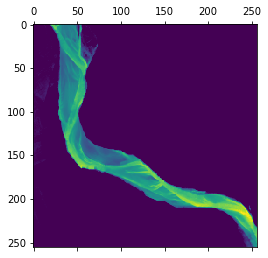

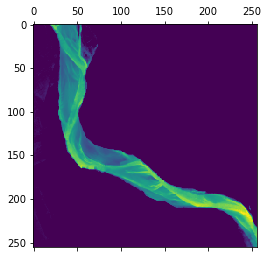

In [52]:
# First train frame
plt.matshow(train_d.__getitem__(1)[0][0][0].reshape(256,256))
print(np.mean(train_d.__getitem__(1)[0][0][0]))

# Last target frame
plt.matshow(train_d.__getitem__(1)[1][0][3].reshape(256,256))
print(np.mean(train_d.__getitem__(1)[1][0][3]))

### Model

In [53]:
import tensorflow.keras.layers 

In [54]:
sample_shape = (10, 256, 256, 1)
inputs = Input(shape = sample_shape)

x = inputs

x = Conv3D(32, kernel_size=(3, 3, 3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=sample_shape)(x)
x = BatchNormalization()(x)
x = AveragePooling3D(pool_size=(2, 2, 2))(x)

x = Conv3D(64, kernel_size=(3, 3, 3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=sample_shape)(x)
x = BatchNormalization()(x)
x = AveragePooling3D(pool_size=(2, 2, 2))(x)

x = Conv3DTranspose(filters=64, kernel_size=(3,3,3), strides=(2,2,2), padding="same",activation='relu')(x)
x = BatchNormalization()(x)

x = Conv3DTranspose(filters=32, kernel_size=(3,3,3), strides=(1,2,2), padding="same",activation='relu')(x)
x = BatchNormalization()(x)

x = Conv3DTranspose(filters=1, kernel_size=(3,3,3), strides=(1,1,1), padding="same",activation='relu')(x)
x = BatchNormalization()(x)

model = Model(inputs, x)

In [55]:
model.compile(optimizer = Adam(learning_rate = 1e-3), loss = "mean_squared_error", metrics = ["accuracy"])

In [56]:
history = LossHistory()

In [57]:
model.fit(
    x = train_d,
    validation_data = test_d,
    use_multiprocessing = True,
    workers = 6,
    epochs = 1,
    callbacks=[history]
)

 76/867 [=>............................] - ETA: 4:12 - loss: 0.3156 - accuracy: 0.6739

Process Keras_worker_ForkPoolWorker-13:
Process Keras_worker_ForkPoolWorker-17:
Traceback (most recent call last):
  File "/home/diego/anaconda3/envs/parflood/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process Keras_worker_ForkPoolWorker-16:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/diego/anaconda3/envs/parflood/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/diego/anaconda3/envs/parflood/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/diego/anaconda3/envs/parflood/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/diego/anaconda3/envs/parflood/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/diego/anaconda3/envs/parflood/lib/python3.6/multiprocessing/pool.py", line 119, in wo

KeyboardInterrupt: 

  File "/home/diego/anaconda3/envs/parflood/lib/python3.6/site-packages/numpy/lib/format.py", line 755, in read_array
    array = numpy.fromfile(fp, dtype=dtype, count=count)
  File "<ipython-input-50-fa419b2b46c1>", line 49, in __getitem__
    X, y = self.__data_generation(indexes)
  File "<ipython-input-50-fa419b2b46c1>", line 100, in __data_generation
    src = np.load(root + dataset_filenames[i])[start:end]
KeyboardInterrupt
  File "/home/diego/anaconda3/envs/parflood/lib/python3.6/site-packages/numpy/lib/npyio.py", line 453, in load
    pickle_kwargs=pickle_kwargs)
  File "/home/diego/anaconda3/envs/parflood/lib/python3.6/site-packages/numpy/lib/format.py", line 755, in read_array
    array = numpy.fromfile(fp, dtype=dtype, count=count)
KeyboardInterrupt


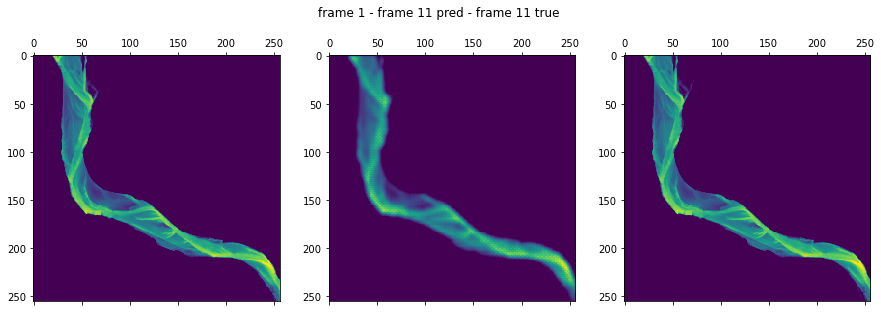

In [58]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
fig.suptitle('frame 1 - frame 11 pred - frame 11 true')

ax1.matshow(test_d.__getitem__(10)[0][0][0].reshape(256,256))
ax2.matshow(model.predict(test_d.__getitem__(10)[0])[0][0].reshape(256,256))
ax3.matshow(test_d.__getitem__(10)[1][0][0].reshape(256,256))

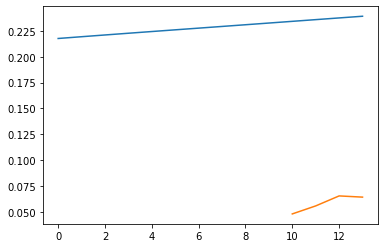

In [76]:
f = np.concatenate((test_d.__getitem__(10)[0][0], test_d.__getitem__(10)[1][0]))
plt.plot(range(14), [np.mean(x) for x in f])

plt.plot(range(10, 14), [np.mean(x) for x in model.predict(test_d.__getitem__(10)[0])[0]])

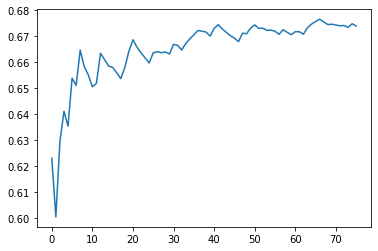

In [59]:
history.accuracy_plot()

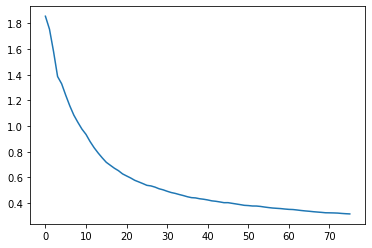

In [60]:
history.loss_plot()